# boardcnn.py EXPLAINED

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf

2021-12-10 02:08:45.198917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-10 02:08:45.198948: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from clusterization import clusterize
from chessutils import find_coeffs

In [3]:
def intersect(i1, i2):
    return (i2[0] <= i1[1]) and (i1[0] <= i2[1])
def closeintervals(i1, i2):
    return intersect(i1, i2) and (abs(i1[2]-i2[2]) == 1)

In [4]:
def centerofmass(c):
    xm = 0
    ym = 0
    nm = 0
    for i in c:
        ns = i[1]-i[0]+1
        xm += 0.5*(i[1]+i[0])*ns
        ym += i[2]*ns
        nm += ns
    return xm/nm, ym/nm

In [5]:
colors = np.array([' ', 'w', 'b'])
figures = np.array([' ','p','b','n','r','q','k'])

In [6]:
NUMCELL = 8
CELL = 60
IMGSIZE = NUMCELL*CELL

In [7]:
#Loading models
model = tf.keras.models.load_model('models/unet_board_v4.h5')
classifier = tf.keras.models.load_model('models/class_figure_col_v2.h5', compile=False)

2021-12-10 02:08:50.134212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-10 02:08:50.134265: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-10 02:08:50.134306: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ilia-ThinkPad-S5-S540): /proc/driver/nvidia/version does not exist
2021-12-10 02:08:50.134639: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#Folder with images
PATH_TO_TST = 'out'

In [9]:
#Images in folder
fl = [os.path.join(PATH_TO_TST, f) for f in os.listdir(PATH_TO_TST) if f.split('.')[-1] == 'png']
fl

['out/90b38ea2-76fb-4411-b9e6-e58520db2d68.png',
 'out/77dabf4d-113d-464e-8914-65b4112f1bad.png',
 'out/46ed618c-d024-41d1-818d-ce1d67c3c239.png',
 'out/46780273-cdcb-4de2-a7c9-4dbc4999c229.png',
 'out/a405f2c7-8bda-489b-8cab-1ffecc1ee938.png',
 'out/62b7a3fa-1dc9-435a-8339-9c1cc2289e8f.png',
 'out/8d524bb4-a17e-4b19-b8df-d25b7063877c.png',
 'out/4008e069-ef77-4956-a390-dfc24ad61694.png',
 'out/37907032-f4f1-464a-a874-8830b4e4bb22.png',
 'out/6a00a3d6-c3d0-42fa-bd11-541de287c861.png',
 'out/7b15810b-5a02-4924-bc56-2eefb7bc8031.png',
 'out/33faa7fb-c1fc-4073-9c0a-1607bcd7b0c1.png']

In [10]:
filename = fl[0]

In [11]:
#Loading image
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (IMGSIZE,IMGSIZE))
feed = np.expand_dims(img/255, axis=(0,-1))
feed.shape

(1, 480, 480, 1)

In [12]:
#Detecting characteristic points
pred = np.squeeze(model.predict(feed))
points = np.argmax(pred, axis=-1)

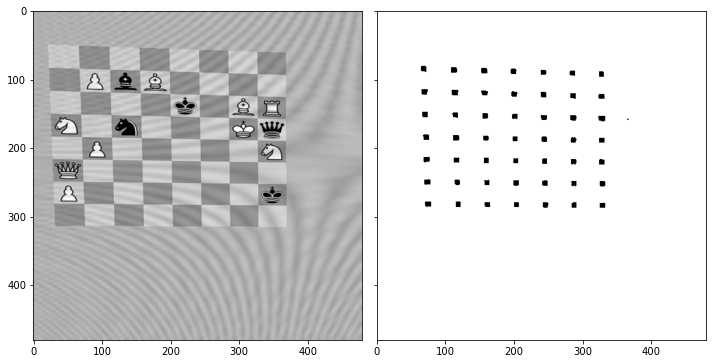

In [13]:
#Visualizing
fig, axx = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)
axx[0].imshow(img, cmap='gray')
axx[1].imshow(points, cmap='gray')
fig.tight_layout()
plt.show()

In [17]:
#Clusterizing points
invpoints = 1-points
xsumms = np.sum(invpoints, axis=-1)
res = []
for y, xsumm in enumerate(xsumms):
    if xsumm == 0:
        continue
    ##TODO extend with zeros??
    s = invpoints[y]
    diffs = s[1:]-s[:-1]
    starts = np.where(diffs==1)[0]
    ends = np.where(diffs==-1)[0]
    for i1, i2 in zip(starts,ends):
        res.append([i1+1,i2,y])
cl = clusterize(res, closeintervals)

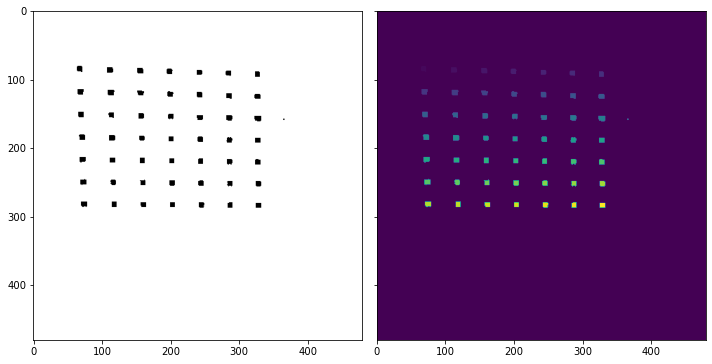

In [18]:
#Visualizing
clcol = np.zeros((IMGSIZE,IMGSIZE), dtype=np.int32)
for i, c in enumerate(cl):
    for k in c:
        clcol[k[2],k[0]:k[1]+1] = i+1

fig, axx = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True, sharex=True)
axx[0].imshow(points, cmap='gray')
axx[1].imshow(clcol, vmin=0, vmax=len(cl))
fig.tight_layout()
plt.show()

In [19]:
#Centers of clusters
xy = np.array(list(map(centerofmass, cl)))
#Mutual center
xyc = np.mean(xy, axis=0)

In [20]:
#(Manhattan) distances between centers and xyc
mhdists = np.array([np.sum(np.abs(p-xyc)) for p in xy])
#Most distant clusters
corners = xy[np.argsort(mhdists)[-4:]]

In [21]:
#half of diagonal
half = 0.5*np.max(mhdists)
#new corners
newc = xyc + half*np.array([[-1,-1],[1,-1],[-1,1],[1,1]])

In [22]:
#matching between initial and new corners
ixmatch = [np.argmin(np.sum(np.abs(p-corners), axis=1)) for p in newc]
cornersmatch = corners[ixmatch]

In [23]:
#widening board
brdsize = half / 6 * NUMCELL
boardcorners = xyc + brdsize*np.array([[-1,-1],[1,-1],[-1,1],[1,1]])

In [24]:
#Transformation coefficients
coeffs = find_coeffs(newc, cornersmatch)

In [25]:
#Transforming/cropping
img = Image.fromarray(img)
img = img.transform(img.size, Image.PERSPECTIVE, coeffs, Image.BICUBIC, fill='white')
img = img.crop((xyc[0]-brdsize, xyc[1]-brdsize, xyc[0]+brdsize, xyc[1]+brdsize))

In [26]:
#resizing
img = img.resize((IMGSIZE,IMGSIZE))

In [27]:
#Separating by fields
cropped = np.asarray(img)
stacked = np.zeros((NUMCELL*NUMCELL,CELL,CELL))
for i in range(NUMCELL*NUMCELL):
    xp = i % NUMCELL
    yp = i // NUMCELL
    stacked[i] = cropped[yp*CELL:(yp+1)*CELL,xp*CELL:(xp+1)*CELL]/255
stacked = np.expand_dims(stacked,axis=-1)

In [28]:
#predicting figures and colors
preds = classifier.predict(stacked)

In [29]:
#Predicted figures
figures[np.argmax(preds[:,0:7],axis=-1)].reshape((8,8))

array([[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', 'p', 'b', 'b', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', 'b', ' ', 'b', 'p'],
       ['n', ' ', 'n', ' ', ' ', ' ', 'n', 'k'],
       [' ', 'p', ' ', ' ', ' ', ' ', ' ', 'n'],
       ['q', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       ['p', ' ', ' ', ' ', ' ', ' ', ' ', 'k'],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']], dtype='<U1')

In [30]:
#Predicted colors
colors[np.argmax(preds[:,7:10],axis=-1)].reshape((8,8))

array([[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', 'w', 'b', 'w', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', 'b', ' ', 'w', 'w'],
       ['w', ' ', 'b', ' ', ' ', ' ', 'w', 'b'],
       [' ', 'w', ' ', ' ', ' ', ' ', ' ', 'w'],
       ['w', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       ['w', ' ', ' ', ' ', ' ', ' ', ' ', 'b'],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']], dtype='<U1')

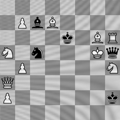

In [31]:
img.resize((120,120))